In [2]:
import os
import random

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

class LinearRegression(torch.nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear1 = torch.nn.Linear(5, 1)

    def forward(self, x):
        x = self.linear1(x)
        return x
    
    
class Model():
    def __init__(self, model):
        self.model = model
        self.optimizer = torch.optim.SGD(self.model.parameters(),
                                         lr=1e-2)
        self.criterion = torch.nn.MSELoss()
        self.loss = []
        print(model)

    def trainAnEpoch(self, inputs, answers):
        outputs = self.model(inputs)
        loss = self.criterion(outputs, answers)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.loss.append(float(loss))

    def predict(self, inputs):
        return self.model(inputs)
    
def loadData():
    dataSet = {}
    validPoints = 0
    totalPoints = 0
    print("Detected stocks: " + str(len(os.listdir("./data/stocks"))))
    for fileName in os.listdir("./data/stocks"):
        dataSet[fileName] = pd.read_csv("./data/stocks/" + fileName,
                                        sep=",",
                                        header=0,
                                        usecols=[4, 13, 14, 15, 16, 17],
                                        encoding="gbk",
                                        dtype="float64"
                                        ).dropna()
        totalPoints += dataSet[fileName].shape[0]
#         for i in range(1, dataSet[fileName].shape[1]):
#             dataSet[fileName].iloc[:, i] = dataSet[fileName].iloc[:, i] - dataSet[fileName].iloc[:, i].mean()
#             dataSet[fileName].iloc[:, i] = dataSet[fileName].iloc[:, i] / dataSet[fileName].iloc[:, i].std()
        if dataSet[fileName].empty:
            # print("Warning: problematic stock dataset " + fileName)
            del dataSet[fileName]
        else:
            
            validPoints += dataSet[fileName].shape[0]
    print("Total data points: " + str(totalPoints))
    print("Valid data points: " + str(validPoints))
    print("Valid stocks: " + str(len(dataSet.keys())))

    return dataSet

## 1. Get dataset

In [3]:
dataSet = loadData()

Detected stocks: 4702
Total data points: 35232
Valid data points: 35232
Valid stocks: 4690


In [14]:
inputs = []
answers = []

for stock in dataSet.values():
    stockInputs = []
    stockTargets = []
    if stock.shape[0] <= 1:
        continue
    for index, row in stock.iterrows():
        stockInputs.append(torch.tensor(np.asarray(row[1:6])))
        stockTargets.append(torch.tensor(row[0]))
    inputs = inputs + stockInputs[1:]
    answers = answers + stockTargets[:-1]
print(len(inputs))
print(len(answers))

30542
30542


In [11]:
inputs = torch.stack(inputs)
answers = torch.stack(answers).reshape(-1,1)

In [12]:
inputs

tensor([[ 8.9639e-04,  8.6545e-01, -4.0066e-02,  1.1655e-02,  4.8644e+00],
        [ 7.1400e-04,  6.8936e-01,  3.8344e-01,  8.1301e-03,  4.8418e+00],
        [ 6.1929e-04,  6.9977e-01, -2.6249e-01,  4.6674e-03,  4.8418e+00],
        ...,
        [ 4.8711e-03,  1.3007e+00,  1.6288e-01,  1.6691e-02,  1.8103e+01],
        [ 4.4268e-03,  1.0277e+00,  9.3026e-01,  4.0495e-02,  1.8569e+01],
        [ 1.1584e-02,  2.6731e+00,  7.3699e-02,  6.0353e-02,  1.9655e+01]],
       dtype=torch.float64)

In [13]:
answers

tensor([[ 0.0023],
        [ 0.0035],
        [-0.0046],
        ...,
        [-0.0253],
        [ 0.0014],
        [ 0.0262]], dtype=torch.float64)

In [6]:
normInputs = []
for i in range(inputs.shape[1]):
    normInputs.append(inputs[:, i])
    print("min: {}".format(normInputs[-1].min()))
    normInputs[-1] = normInputs[-1]-normInputs[-1].min()
    print("max: {}".format(normInputs[-1].max()))
    normInputs[-1] = normInputs[-1]/normInputs[-1].max()
inputs = torch.stack(normInputs,dim=1)

min: 0.0
max: 0.78178930534733
min: 0.0
max: 18.329095033429
min: -1.0
max: 2.0
min: 0.0
max: 0.28878923766816
min: -39400.0
max: 44680.0


### 1.1 Research data

In [85]:
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
y = []
for i in range(len(inputs)):
    x1.append(float(inputs[i, 0]))
    x2.append(float(inputs[i, 1]))
    x3.append(float(inputs[i, 2])**4)
    x4.append(float(inputs[i, 3]))
    x5.append(float(inputs[i, 4])**2)

for i in range(answers.shape[0]):
    y.append(float(answers[i, 0]))

#### P-value

In [86]:
ttest_ind(y, x1)

Ttest_indResult(statistic=-87.23052246889763, pvalue=0.0)

In [87]:
ttest_ind(y, x2)

Ttest_indResult(statistic=-235.69070363822078, pvalue=0.0)

In [88]:
ttest_ind(y, x3)

Ttest_indResult(statistic=-65.15370224301905, pvalue=0.0)

In [89]:
ttest_ind(y, x4)

Ttest_indResult(statistic=-164.758796346903, pvalue=0.0)

In [90]:
ttest_ind(y, x5)

Ttest_indResult(statistic=-3.5705338483408275, pvalue=0.0003565328062723153)

#### var

In [94]:
total = torch.cat((inputs, answers), dim = 1).T

In [95]:
total

tensor([[ 8.9639e-04,  7.1400e-04,  6.1929e-04,  ...,  4.8711e-03,
          4.4268e-03,  1.1584e-02],
        [ 8.6545e-01,  6.8936e-01,  6.9977e-01,  ...,  1.3007e+00,
          1.0277e+00,  2.6731e+00],
        [-4.0066e-02,  3.8344e-01, -2.6249e-01,  ...,  1.6288e-01,
          9.3026e-01,  7.3699e-02],
        [ 1.1655e-02,  8.1301e-03,  4.6674e-03,  ...,  1.6691e-02,
          4.0495e-02,  6.0353e-02],
        [ 4.8644e+00,  4.8418e+00,  4.8418e+00,  ...,  1.8103e+01,
          1.8569e+01,  1.9655e+01],
        [ 2.3360e-03,  3.4970e-03, -4.6460e-03,  ..., -2.5287e-02,
          1.4310e-03,  2.6203e-02]], dtype=torch.float64)

In [96]:
 torch.corrcoef(total)

tensor([[ 1.0000,  0.3225,  0.0771,  0.5874,  0.0069,  0.2465],
        [ 0.3225,  1.0000, -0.0199,  0.5196, -0.0082,  0.2629],
        [ 0.0771, -0.0199,  1.0000,  0.0355,  0.0124,  0.0257],
        [ 0.5874,  0.5196,  0.0355,  1.0000,  0.0014,  0.2162],
        [ 0.0069, -0.0082,  0.0124,  0.0014,  1.0000, -0.0058],
        [ 0.2465,  0.2629,  0.0257,  0.2162, -0.0058,  1.0000]],
       dtype=torch.float64)

##### 1.1.1 visualization y

(array([2.240e+02, 4.950e+02, 7.730e+02, 1.647e+03, 2.524e+03, 3.654e+03,
        4.189e+03, 5.104e+03, 3.978e+03, 2.614e+03, 1.487e+03, 9.660e+02,
        6.450e+02, 5.130e+02, 2.760e+02, 1.820e+02, 1.050e+02, 7.200e+01,
        5.000e+01, 4.190e+02, 9.000e+00, 6.000e+00, 9.000e+00, 8.000e+00,
        4.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 2.600e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-0.058583  , -0.05045175, -0.0423205 , -0.03418925, -0.026058  ,
        -0.01792675, -0.0097955 , -0.00166425,  0.006467  ,  0.01459825,
         0.0227295 ,  0.03086075,  0.038992  ,  0.04712325,  0.0552545 ,
         0.06338575,  0.071517  ,  0.07964825,  0.0877795 ,  0.09591075,
         0.104042  ,  0.11217325,  0.1203045 ,  0.12843575,  0.136567  ,
         0.14469825,  0.1528295 ,  0.16096075,  0.169092  ,  0.17722325,
         0.1853545 ,  0.19348575,  0.201617  ,  0.20974825,  0.2

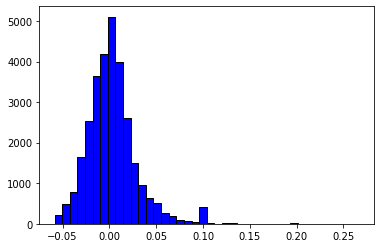

In [419]:
plt.hist(y, bins = 40, facecolor = "blue", edgecolor="black")

#### 1.1.2 Visualization x1

(array([1.8655e+04, 6.6380e+03, 2.2440e+03, 1.0000e+03, 5.0700e+02,
        3.1100e+02, 1.7200e+02, 1.0700e+02, 9.4000e+01, 6.2000e+01,
        5.1000e+01, 2.4000e+01, 2.5000e+01, 1.9000e+01, 2.3000e+01,
        1.6000e+01, 3.0000e+00, 5.0000e+00, 8.0000e+00, 6.0000e+00,
        3.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <BarContainer object of 40 artists>)

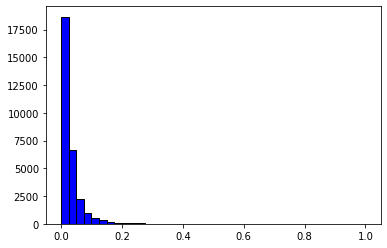

In [420]:
plt.hist(x1, bins = 40, facecolor = "blue", edgecolor="black")

#### 1.1.2 Visualization x2

(array([1.8560e+03, 1.5771e+04, 7.6670e+03, 2.4010e+03, 1.0190e+03,
        4.7100e+02, 2.7500e+02, 1.6600e+02, 1.0800e+02, 7.9000e+01,
        3.8000e+01, 3.5000e+01, 1.8000e+01, 1.6000e+01, 1.4000e+01,
        7.0000e+00, 1.4000e+01, 5.0000e+00, 5.0000e+00, 4.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <BarContainer object of 40 artists>)

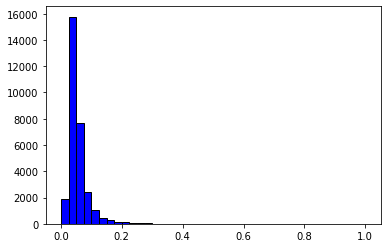

In [421]:
plt.hist(x2, bins = 40, facecolor = "blue", edgecolor="black")

#### 1.1.2 Visualization x3

(array([  40.,   76.,  113.,  146.,  215.,  277.,  350.,  395.,  529.,
         567.,  680.,  750.,  870.,  891., 1063., 1039., 1277., 1274.,
        1542., 1946., 2322., 1629., 1457., 1315., 1164., 1075.,  959.,
         885.,  843.,  756.,  693.,  528.,  497.,  391.,  313.,  251.,
         191.,  123.,   70.,  487.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <BarContainer object of 40 artists>)

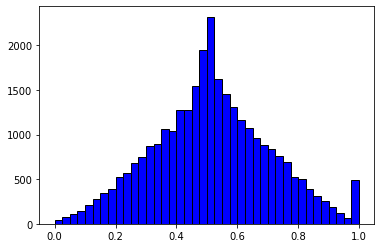

In [422]:
plt.hist(x3, bins = 40, facecolor = "blue", edgecolor="black")

#### 1.1.2 Visualization x4

(array([4.180e+02, 1.983e+03, 4.966e+03, 5.930e+03, 4.744e+03, 3.487e+03,
        2.467e+03, 1.625e+03, 1.140e+03, 8.170e+02, 5.340e+02, 4.050e+02,
        3.100e+02, 3.070e+02, 2.300e+02, 1.940e+02, 1.110e+02, 6.100e+01,
        5.000e+01, 5.200e+01, 1.500e+01, 2.300e+01, 1.200e+01, 2.600e+01,
        1.500e+01, 1.000e+01, 1.000e+01, 1.400e+01, 8.000e+00, 1.000e+01,
        3.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <BarContainer object of 40 artists>)

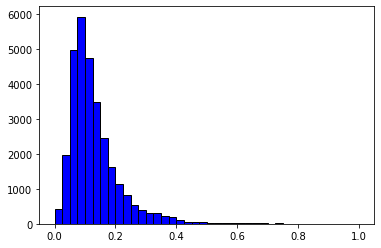

In [423]:
plt.hist(x4, bins = 40, facecolor = "blue", edgecolor="black")

#### 1.1.2 Visualization x5

(array([5.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.0000e+00, 3.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4000e+01, 0.0000e+00,
        0.0000e+00, 7.0000e+00, 2.0000e+01, 6.4000e+01, 3.9700e+02,
        2.9302e+04, 1.0700e+02, 3.4000e+01, 2.3000e+01, 7.0000e+00]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <BarContainer object of 40 artists>)

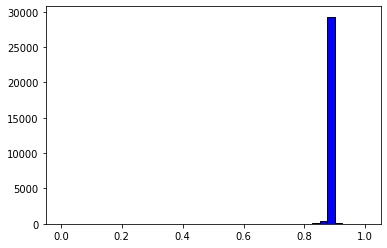

In [424]:
plt.hist(x5, bins = 40, facecolor = "blue", edgecolor="black")

## 2. Split dataset into train and test

In [425]:
testIndexs = random.sample(range(0, len(answers) - 1), 10000)
train = []
trainAns = []
test = []
testAns = []
for i in range(len(answers)):
    if i not in testIndexs:
        train.append(inputs[i])
        trainAns.append(answers[i])
    else:
        test.append(inputs[i])
        testAns.append(answers[i])
train = torch.stack(train).float()
trainAns = np.reshape(torch.stack(trainAns).float(), (-1, 1))
test = torch.stack(test).float()
testAns = np.reshape(torch.stack(testAns).float(), (-1, 1))

## 3. Set up model and training...

In [426]:
model = Model(LinearRegression())

LinearRegression(
  (linear1): Linear(in_features=5, out_features=1, bias=True)
)


In [427]:
diffs = []
for epoch in range(100):
    model.trainAnEpoch(train, trainAns)
    predict = model.predict(test)
    diff = torch.abs(testAns-predict).mean().item()
    diffs.append(diff)
#     print(list(model.model.parameters()))
    print("Epoch {}, loss {}, predict {}".format(epoch, model.loss[-1], predict.mean()))

Epoch 0, loss 0.1085614413022995, predict -0.3052663207054138
Epoch 1, loss 0.09999532997608185, predict -0.29239505529403687
Epoch 2, loss 0.09212355315685272, predict -0.2800566852092743
Epoch 3, loss 0.08488979935646057, predict -0.268229216337204
Epoch 4, loss 0.07824233174324036, predict -0.2568913996219635
Epoch 5, loss 0.0721336379647255, predict -0.24602308869361877
Epoch 6, loss 0.06652000546455383, predict -0.23560473322868347
Epoch 7, loss 0.06136131286621094, predict -0.22561776638031006
Epoch 8, loss 0.056620653718709946, predict -0.21604429185390472
Epoch 9, loss 0.05226413905620575, predict -0.20686721801757812
Epoch 10, loss 0.048260632902383804, predict -0.19807013869285583
Epoch 11, loss 0.04458151012659073, predict -0.18963730335235596
Epoch 12, loss 0.04120046645402908, predict -0.1815536469221115
Epoch 13, loss 0.03809332847595215, predict -0.17380473017692566
Epoch 14, loss 0.03523790463805199, predict -0.16637663543224335
Epoch 15, loss 0.032613761723041534, pred

## 4. Visualization loss

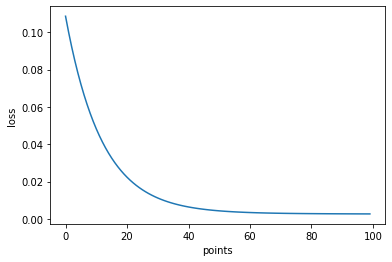

In [428]:
plt.plot(model.loss)
plt.ylabel("loss")
plt.xlabel("points")
plt.show()

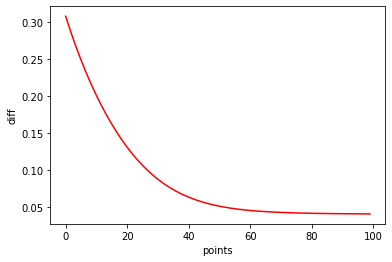

In [429]:
plt.plot(diffs, color="red")
plt.ylabel("diff")
plt.xlabel("points")
plt.show()

## 5. test

### 5.1 Sampling

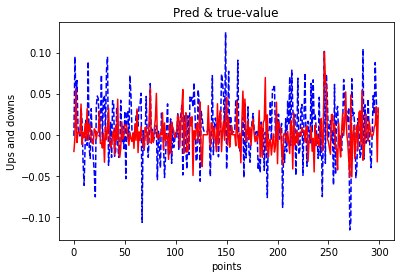

In [437]:
predict = model.predict(test)
plt.plot(torch.detach(predict[:300]), color="blue", linestyle='dashed', label="predict")
plt.plot(testAns[:300], color="red", label="answer")
plt.ylabel("Ups and downs")
plt.xlabel("points")
plt.title("Pred & true-value")
plt.show()

Text(0.5, 1.0, 'Error fluctuation')

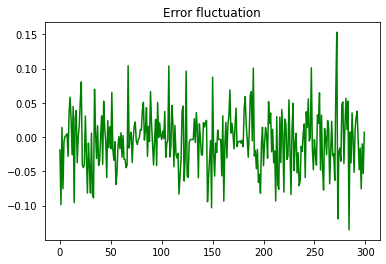

In [436]:
plt.plot(torch.detach(testAns-predict)[:300], color="green")
plt.title("Error fluctuation")

In [438]:
print("ave diff: {}".format(torch.abs(testAns-predict).mean()))

ave diff: 0.04089708998799324


In [440]:
print("std of diffs: {}".format(torch.abs(testAns-predict).std()))

std of diffs: 0.03328888863325119


In [441]:
print("largest diff: {}".format(torch.abs(testAns-predict).max()))

largest diff: 0.27044349908828735


### 5.2 Average test

### 5.3 ranking test

In [450]:
inputDate = pd.read_csv("./data/2021-12-28.csv",
                       sep=",",
                       header=0,
                       usecols=[0, 13, 14, 15, 16, 17],
                       encoding="gbk",
                      dtype="float64").dropna()
targetDate = pd.read_csv("./data/2021-12-28.csv",
                       sep=",",
                       header=0,
                       usecols=[0],
                       encoding="gbk",
                      dtype="float64").dropna()
targetDate

,代码
0,688206.0
1,1301166.0
2,1300075.0
3,1300412.0
4,1300233.0
...,...
4411,601016.0
4412,1002763.0
4413,1300152.0
4414,1002608.0


In [451]:
for i in range(1, inputDate.shape[1]):
    print("Max: {}, Min: {}".format(inputDate.iloc[:,i].max(), inputDate.iloc[:,i].min()))
    inputDate.iloc[:,i] = inputDate.iloc[:,i]-inputDate.iloc[:,i].min()
    inputDate.iloc[:,i] = inputDate.iloc[:,i]/inputDate.iloc[:,i].max()
inputDate

Max: 19.533357499597, Min: 0.0
Max: 1.0, Min: -0.97355081442765
Max: 0.24945560125817, Min: 0.0
Max: 11077.192982456, Min: -39400.0
Max: 2693275521222.0, Min: 122253074.4


,代码,量比,委比,振幅,市盈率,流通市值
2,1300075.0,0.136180,1.000000,0.817342,0.781339,0.002977
3,1300412.0,0.069778,1.000000,0.770688,0.781734,0.001552
4,1300233.0,0.220128,1.000000,0.827702,0.780104,0.004753
5,1300248.0,0.069490,1.000000,0.853524,0.781314,0.002079
6,1300261.0,0.067109,1.000000,0.376524,0.782500,0.006808
...,...,...,...,...,...,...
4411,601016.0,0.031201,0.593965,0.158008,0.781369,0.011018
4412,1002763.0,0.065570,0.566181,0.148761,0.780813,0.001453
4413,1300152.0,0.037314,0.785759,0.145112,0.830544,0.001090
4414,1002608.0,0.042561,0.498262,0.152016,0.780862,0.009648


In [452]:
inputpoints = []
for index, inputpoint in inputDate.iterrows():
    predict = model.predict(torch.tensor(np.asarray(inputpoint[1:])).float())
    inputpoints.append([int(inputpoint[0].item()), predict.item()])
inputpoints = sorted(inputpoints, key=lambda x: x[1], reverse=True)

In [453]:
targetDate = [int(targetDate.iloc[i,0]) for i in range(50)]
inputpoints = [inputpoints[i][0] for i in range(50)]

print("Hit rate: {}".format(len([code for code in targetDate if code in inputpoints])/50))

Hit rate: 0.04


## 6. Model

In [ ]:
list(model.model.parameters())